Martin Loza

23/12/16

In this workflow I would like to obtaein the average a HiC file. 
I would like to loop over different resolutions to calculate the average.
For now, I am obtaining the average as a bedpe file.

This workflow follows the code made on "test_average_hic.ipynb" on 23/12/18.

In [3]:
# Init libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

scaler = StandardScaler()

# Global variables
in_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12/2023_12_19/Results/"
out_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12/2023_12_19/Results/"

# Local functions

#Function to filter ids appearing in less than n cell types
def filter_ids(df,n_cells=5, column='count'):
    # count the number of elements per id
    tmp = df.groupby('id')[column].count()
    # ids of intereaction appearing in n cell types
    ids = tmp[tmp == n_cells].index
    # filter the data
    df = df[df['id'].isin(ids)]
    
    # histogram of interaction in less than n cell types
    plt.hist(tmp[tmp < n_cells], bins=10)
    plt.title(f"Distribution of Interaction IDs with Less than {n_cells} Elements\nColumn: {column}")
    plt.xlabel("Number of Elements")
    plt.ylabel("Frequency")
    plt.show()
    
    return df

# Function to replace NaN values with a value outside the range of the data
def replace_nan(df, column='scaled', replace_with=-10):
        
    #if the value is true, throw a warning and change the nan_value to something more appropriate
    if data['scaled'].min() < replace_with:
        # Change the value based on the minimum value of the scaled data
        replace_with = round(data['scaled'].min() - 1)  
        warnings.warn(f"The replace_with is not outside the range of the scaled data. Changing the value to: {nan_value}")
        
    # replace the NaN values with the nan_value
    df[column] = df[column].fillna(replace_with)
    
    return df


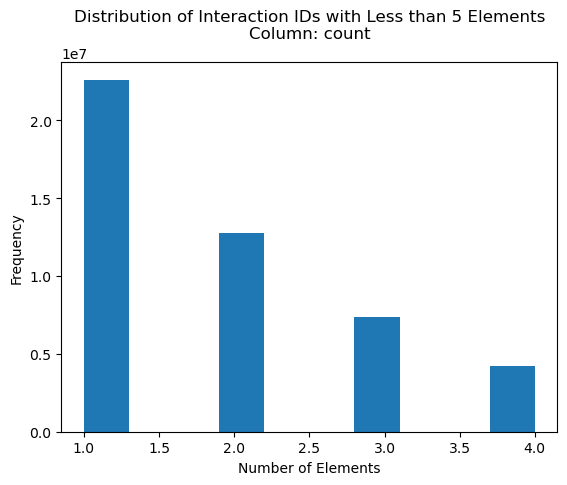

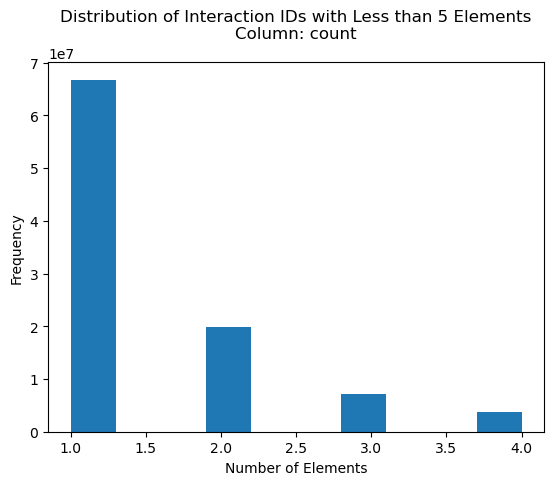

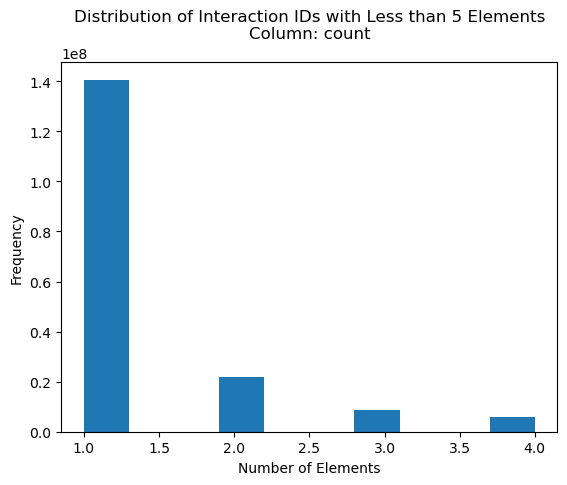

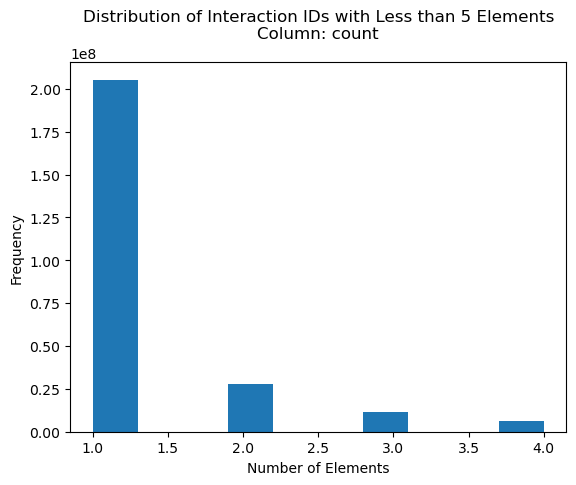

In [5]:
# Define a list of resolutions
resolutions = [50000, 25000, 10000, 5000]
# resolutions = [5000000, 2500000, 1000000, 500000, 250000, 100000]
#resolutions = ['1000', '10000', '100000', '1000000', '2000', '25000', '250000', '2500000', '5000', '50000', '500000', '5000000']

# Loop over the resolutions
for resolution in resolutions:
    # Load the data for the current resolution
    data = pd.read_csv(in_dir + f"scaled_matrix_{resolution}.csv")
    
    #I need to average the scaled data for each interaction.
    # Then, I need to add an interaction_id, then group by interaction (or loop by interaction) to average the scaled data.
    # This can be a bit time consuming for high resolution bins.
    
    # add interaction id
    data['id'] = data['chrom1'] + '_' + data['start1'].astype(str) + '_' + data['chrom2'] + '_' + data['start2'].astype(str)
    
    #Filter interactions that doesn't appear in all cell types using the local function
    data = filter_ids(data, n_cells=5, column='count')
    
    # Replace NaN values with a value outside the range of the data
    data = replace_nan(data, column='scaled', replace_with=-10)
    # short test to make sure everything is working
    test = data['scaled'].isna().sum()
    if(test > 0):
        print(f"There are {test} NaN values in the scaled column after replacing them with an arbitrary value.")
        #stop the loop if there are still NaN values
        break
        
    # Group by interaction id and average the scaled values
    mean_values = data.groupby('id')['scaled'].mean()
    # Convert the mean_values series to a dataframe and reset the index
    mean_values = mean_values.reset_index()
    # Rename the columns
    mean_values.columns = ['id', 'mean']
    
    # Create a new dataframe to store the mean values
    # we can filter the data for only one cell type and remove the unnecessary columns
    data_mean = data[data['cell_type'] == "GM12878"].copy()
    # select only the columns we need
    data_mean = data_mean[['id', 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
    
    # Merge the mean_values with the data_mean dataframe
    data_mean = data_mean.merge(mean_values, on='id', how='left')
    
        
    # Save the results for the current resolution
    data_mean.to_csv(out_dir + f"mean_values_{resolution}.tsv", index=False, header=True, sep='\t')
